# Bio-Signal Analysis for Smoking Prediction

## Problems

Binary Classification $\begin{cases}1&\text{smoking}\\0&\text{No smoking}\end{cases}$

Conducting analysis on bio-signals
Identifying smoking patterns based on certain features: based on the provided data, such as age, gender, and health indicators
Assesing health indicators : Evaluate the impact of smoking on various health indicators, such as hemoglobin, gender, and age, to better understand its health consequences
Identinfying key health indicators affected when a person is a smoker

## Import library & load data

In [22]:
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install seaborn
!pip install Jinja2  
# needed by dataframe.format
!pip install scipy 
# needed by kendall measurement
!pip install scikit-learn


   ---------------------------------------- 0.0/9.1 MB ? eta -:--:--
   ---------------------------------------- 0.1/9.1 MB 3.3 MB/s eta 0:00:03
   -- ------------------------------------- 0.5/9.1 MB 6.2 MB/s eta 0:00:02
   ---- ----------------------------------- 1.0/9.1 MB 7.9 MB/s eta 0:00:02
   ------- -------------------------------- 1.6/9.1 MB 9.4 MB/s eta 0:00:01
   --------- ------------------------------ 2.2/9.1 MB 10.2 MB/s eta 0:00:01
   ------------- -------------------------- 3.1/9.1 MB 11.5 MB/s eta 0:00:01
   ---------------- ----------------------- 3.8/9.1 MB 12.2 MB/s eta 0:00:01
   -------------------- ------------------- 4.6/9.1 MB 13.3 MB/s eta 0:00:01
   ------------------------ --------------- 5.6/9.1 MB 14.3 MB/s eta 0:00:01
   ---------------------------- ----------- 6.5/9.1 MB 14.8 MB/s eta 0:00:01
   -------------------------------- ------- 7.5/9.1 MB 15.5 MB/s eta 0:00:01
   ----------------------------------- ---- 8.1/9.1 MB 15.6 MB/s eta 0:00:01
   --------

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler #for standardization
import warnings
warnings.filterwarnings("ignore")

In [61]:
smoking = pd.read_csv("./data/smoking.csv")
print(smoking.shape)
smoking = smoking.drop_duplicates()
print(smoking.shape)


(55692, 27)
(55692, 27)


In [65]:
df.head(5)

,gender,age,height_cm,weight_kg,waist_cm,eyesight_left,eyesight_right,hearing_left,hearing_right,systolic,...,hemoglobin,urine_protein,serum_creatinine,ast,alt,gtp,oral,dental_caries,tartar,smoking
0,F,40,155,60,81.3,1.2,1.0,1.0,1.0,114.0,...,12.9,1.0,0.7,18.0,19.0,27.0,Y,0,Y,0
1,F,40,160,60,81.0,0.8,0.6,1.0,1.0,119.0,...,12.7,1.0,0.6,22.0,19.0,18.0,Y,0,Y,0
2,M,55,170,60,80.0,0.8,0.8,1.0,1.0,138.0,...,15.8,1.0,1.0,21.0,16.0,22.0,Y,0,N,1
3,M,40,165,70,88.0,1.5,1.5,1.0,1.0,100.0,...,14.7,1.0,1.0,19.0,26.0,18.0,Y,0,Y,0
4,F,40,155,60,86.0,1.0,1.0,1.0,1.0,120.0,...,12.5,1.0,0.6,16.0,14.0,22.0,Y,0,N,0


## EDA

In [66]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55692 entries, 0 to 55691
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   gender               55692 non-null  object 
 1   age                  55692 non-null  int64  
 2   height_cm            55692 non-null  int64  
 3   weight_kg            55692 non-null  int64  
 4   waist_cm             55692 non-null  float64
 5   eyesight_left        55692 non-null  float64
 6   eyesight_right       55692 non-null  float64
 7   hearing_left         55692 non-null  float64
 8   hearing_right        55692 non-null  float64
 9   systolic             55692 non-null  float64
 10  relaxation           55692 non-null  float64
 11  fasting_blood_sugar  55692 non-null  float64
 12  cholesterol          55692 non-null  float64
 13  triglyceride         55692 non-null  float64
 14  hdl                  55692 non-null  float64
 15  ldl                  55692 non-null 

In [157]:
df.apply(np.unique, axis=0)

gender                                                            [0, 1]
age                    [20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 7...
height_cm              [130, 135, 140, 145, 150, 155, 160, 165, 170, ...
weight_kg              [30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 8...
waist_cm               [51.0, 53.0, 54.0, 55.0, 56.0, 56.2, 56.4, 56....
eyesight_left          [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, ...
eyesight_right         [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, ...
hearing_left                                                  [1.0, 2.0]
hearing_right                                                 [1.0, 2.0]
systolic               [71.0, 72.0, 74.0, 79.0, 80.0, 81.0, 82.0, 83....
relaxation             [40.0, 42.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49....
fasting_blood_sugar    [46.0, 48.0, 51.0, 54.0, 55.0, 56.0, 57.0, 58....
cholesterol            [55.0, 72.0, 77.0, 84.0, 86.0, 87.0, 90.0, 91....
triglyceride           [8.0, 11.0, 15.0, 16.0, 19.0

From decription information befroe:
1.  There are totally 0 null values in the dataset. 
2.  Of the variables' data types, 18 are float, 5 are integer and 3 are object.
3.  All oral values are Y. So the variable oral can not help.

gender           None
dental_caries    None
tartar           None
smoking          None
dtype: object

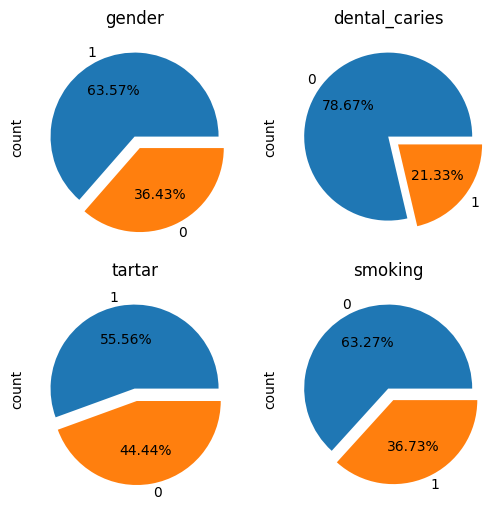

In [143]:

fig, axes =  plt.subplots(2, 2, figsize = (6, 6))
ax, axes = 0, axes.flatten()

def pie_plt(data):
    global ax
    data.value_counts().plot.pie(explode = [0, 0.15], autopct='%1.2f%%', ax=axes[ax]
                                 ).set(title = data.name)
    ax += 1
# df[['smoking', 'gender', 'urine_protein', 'dental_caries', 'tartar']].apply(pie_plt, axis=0)
df.select_dtypes('int').drop(columns=['age', 'height_cm', 'weight_kg']).apply(pie_plt, axis=0)

From pie chart of smoking, it is a unbalanced dataset

age              None
height_cm        None
weight_kg        None
urine_protein    None
dtype: object

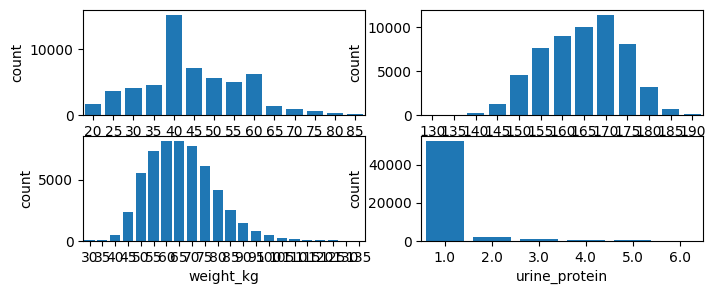

In [159]:
fig, axes = plt.subplots(2, 2, figsize = (8, 3))
ax, axes = 0, axes.flatten()

def bar_plt(data):
    global ax
    sns.barplot(ax = axes[ax],
                x = data.value_counts().index,
                y = data.value_counts(),
                saturation = 1)
    ax += 1
df[['age', 'height_cm', 'weight_kg', 'urine_protein']].apply(bar_plt, axis=0)


In [158]:
df.select_dtypes('float').apply(np.unique, axis=0)

waist_cm               [51.0, 53.0, 54.0, 55.0, 56.0, 56.2, 56.4, 56....
eyesight_left          [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, ...
eyesight_right         [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, ...
hearing_left                                                  [1.0, 2.0]
hearing_right                                                 [1.0, 2.0]
systolic               [71.0, 72.0, 74.0, 79.0, 80.0, 81.0, 82.0, 83....
relaxation             [40.0, 42.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49....
fasting_blood_sugar    [46.0, 48.0, 51.0, 54.0, 55.0, 56.0, 57.0, 58....
cholesterol            [55.0, 72.0, 77.0, 84.0, 86.0, 87.0, 90.0, 91....
triglyceride           [8.0, 11.0, 15.0, 16.0, 19.0, 20.0, 21.0, 22.0...
hdl                    [4.0, 11.0, 14.0, 17.0, 18.0, 21.0, 22.0, 23.0...
ldl                    [1.0, 4.0, 7.0, 9.0, 10.0, 11.0, 12.0, 13.0, 1...
hemoglobin             [4.9, 5.0, 5.5, 5.8, 5.9, 6.1, 6.2, 6.3, 6.4, ...
urine_protein                             [1.0, 2.0

waist_cm               None
eyesight_left          None
eyesight_right         None
systolic               None
relaxation             None
fasting_blood_sugar    None
cholesterol            None
triglyceride           None
hdl                    None
ldl                    None
hemoglobin             None
serum_creatinine       None
ast                    None
alt                    None
gtp                    None
dtype: object

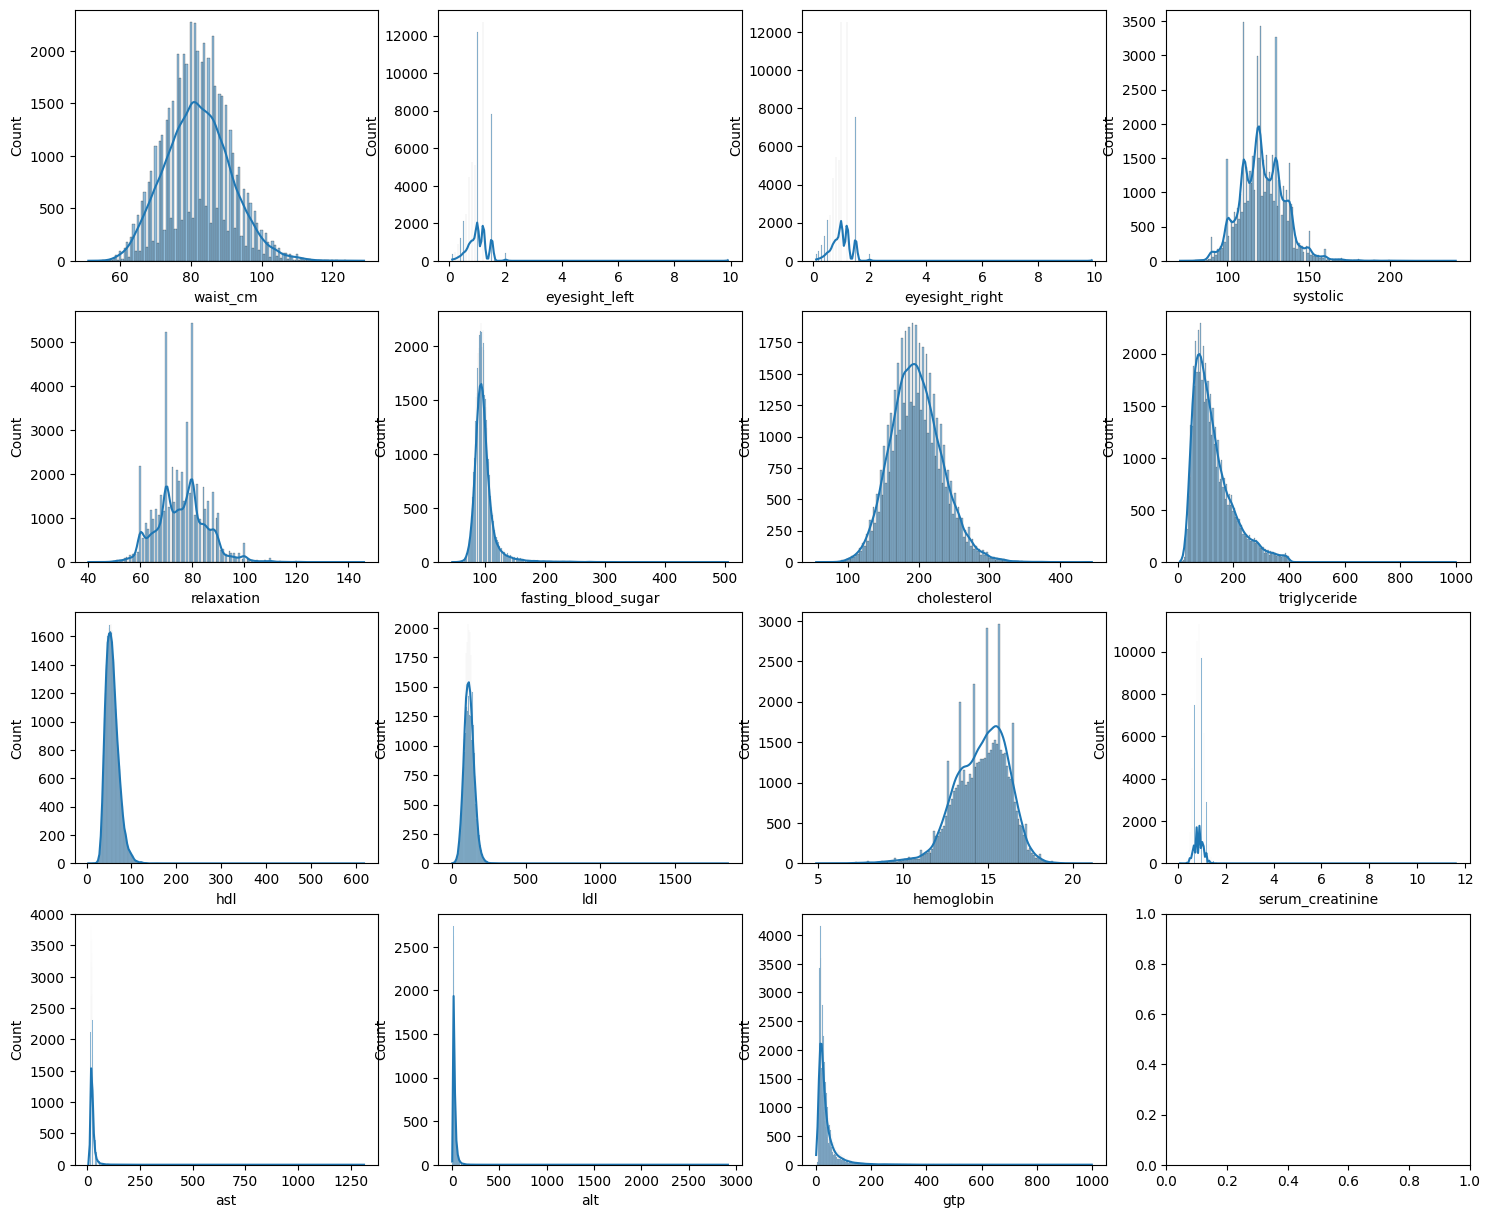

In [160]:
fig, axes = plt.subplots(4, 4, figsize = (18, 15))
ax, axes = 0, axes.flatten()

def hist_plt(data):
    global ax
    sns.histplot(ax=axes[ax],
                x=data, kde=True)
    ax += 1
df.select_dtypes('float').drop(columns=['hearing_left', 'hearing_right','urine_protein']).apply(hist_plt, axis=0)

In [69]:
df = df.drop('oral', axis=1)
df['gender'] = df['gender'].map({'M':1, 'F':0})
df['tartar'] = df['tartar'].map({'Y':1, 'N':0})
df.head(3)

,gender,age,height_cm,weight_kg,waist_cm,eyesight_left,eyesight_right,hearing_left,hearing_right,systolic,...,ldl,hemoglobin,urine_protein,serum_creatinine,ast,alt,gtp,dental_caries,tartar,smoking
0,0,40,155,60,81.3,1.2,1.0,1.0,1.0,114.0,...,126.0,12.9,1.0,0.7,18.0,19.0,27.0,0,1,0
1,0,40,160,60,81.0,0.8,0.6,1.0,1.0,119.0,...,127.0,12.7,1.0,0.6,22.0,19.0,18.0,0,1,0
2,1,55,170,60,80.0,0.8,0.8,1.0,1.0,138.0,...,151.0,15.8,1.0,1.0,21.0,16.0,22.0,0,0,1


In [70]:
df.corr(# Pearson, linear relationship
    ).style.format('{:.2f}'
                   ).background_gradient(cmap = "Oranges"
                                         ).set_properties(**{'max-width': '111px', }) 

,gender,age,height_cm,weight_kg,waist_cm,eyesight_left,eyesight_right,hearing_left,hearing_right,systolic,relaxation,fasting_blood_sugar,cholesterol,triglyceride,hdl,ldl,hemoglobin,urine_protein,serum_creatinine,ast,alt,gtp,dental_caries,tartar,smoking
gender,1.00,-0.29,0.74,0.57,0.42,0.13,0.13,-0.01,-0.01,0.17,0.18,0.10,-0.09,0.24,-0.31,-0.04,0.70,0.02,0.51,0.10,0.17,0.24,0.08,0.06,0.51
age,-0.29,1.00,-0.48,-0.32,-0.03,-0.20,-0.19,0.20,0.21,0.13,0.05,0.18,0.06,0.02,0.01,0.04,-0.26,0.03,-0.11,0.03,-0.06,0.01,-0.11,-0.08,-0.16
height_cm,0.74,-0.48,1.00,0.68,0.38,0.15,0.16,-0.08,-0.08,0.08,0.11,0.02,-0.08,0.16,-0.21,-0.05,0.54,0.01,0.38,0.04,0.13,0.14,0.08,0.06,0.40
weight_kg,0.57,-0.32,0.68,1.00,0.82,0.11,0.11,-0.05,-0.05,0.27,0.27,0.14,0.03,0.32,-0.36,0.04,0.49,0.03,0.32,0.12,0.25,0.21,0.07,0.06,0.30
waist_cm,0.42,-0.03,0.38,0.82,1.00,0.03,0.04,0.02,0.02,0.32,0.29,0.21,0.07,0.36,-0.38,0.07,0.39,0.05,0.24,0.14,0.25,0.24,0.04,0.05,0.23
eyesight_left,0.13,-0.20,0.15,0.11,0.03,1.00,0.35,-0.05,-0.05,-0.02,0.01,-0.04,-0.00,0.02,-0.02,-0.01,0.10,-0.00,0.07,-0.01,0.02,0.00,0.00,0.01,0.06
eyesight_right,0.13,-0.19,0.16,0.11,0.04,0.35,1.00,-0.04,-0.05,-0.01,0.01,-0.04,-0.01,0.02,-0.02,-0.01,0.10,-0.01,0.05,-0.01,0.02,0.01,0.02,0.01,0.06
hearing_left,-0.01,0.20,-0.08,-0.05,0.02,-0.05,-0.04,1.00,0.51,0.06,0.01,0.04,-0.02,0.00,-0.02,-0.02,-0.03,0.01,0.00,0.02,0.00,0.01,-0.02,-0.04,-0.02
hearing_right,-0.01,0.21,-0.08,-0.05,0.02,-0.05,-0.05,0.51,1.00,0.05,0.00,0.04,-0.02,0.00,-0.02,-0.02,-0.03,0.02,0.01,0.01,-0.01,0.01,-0.02,-0.03,-0.02
systolic,0.17,0.13,0.08,0.27,0.32,-0.02,-0.01,0.06,0.05,1.00,0.76,0.17,0.06,0.20,-0.09,0.02,0.19,0.05,0.07,0.08,0.09,0.17,0.03,0.01,0.07


From the correlation heatmap, smoking has a closer linear correlation with gender(0.51), hemoglobin(0.40), height(0.40), weight(0.30). 


However, according to common sence, height should not be one of factors to smoking. It can seen that height has a closer linear correlation with gender(0.74), weight(0.68), hemoglobin(0.54) which are much related to smoking. $\impliedby$ **Guess 1 Colinear Problem exists.**

### gender

array([<Axes: ylabel='No smoking'>, <Axes: ylabel='Smoking'>],
      dtype=object)

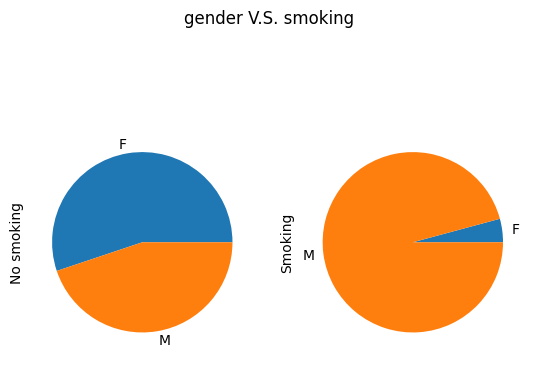

In [71]:
plt.style.use('default')

pd.crosstab(df['gender'].map({0:'F', 1:'M'}), df['smoking'].map({0: 'No smoking', 1:'Smoking'})
            ).plot(kind='pie', subplots=True, stacked=True, title='gender V.S. smoking', legend=False )

### hemoglobin：血红蛋白含量

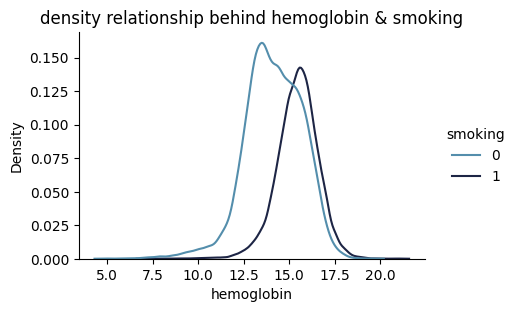

In [72]:
sns.displot(
    data=df, x='hemoglobin', hue='smoking',
    kind='kde', height=3, aspect=1.5,
    palette="ch:rot=-.25,hue=1,light=.50"
).set(title='density relationship behind hemoglobin & smoking')

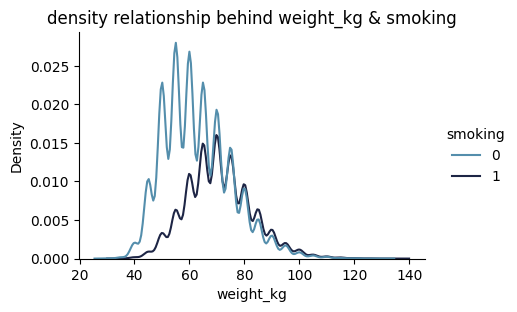

In [73]:
sns.displot(
    data=df, x='weight_kg', hue='smoking', 
    kind='kde', height=3, aspect=1.5,
    palette="ch:rot=-.25,hue=1,light=.50"
).set(title='density relationship behind weight_kg & smoking')

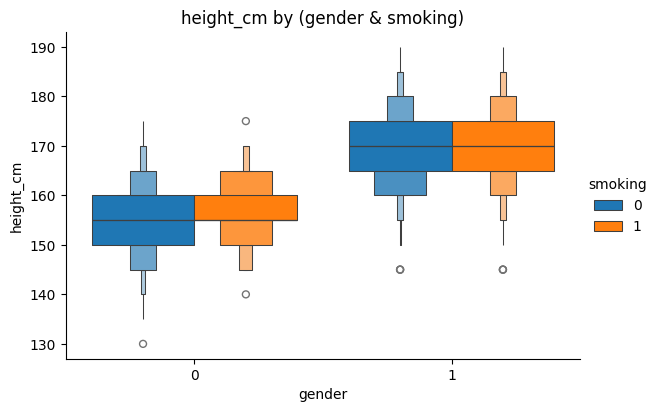

In [74]:
sns.catplot(data=df, x='gender', y='height_cm', hue='smoking',
            kind='boxen', saturation=1, height=4, aspect=1.5 
            ).set(title='height_cm by (gender & smoking)')

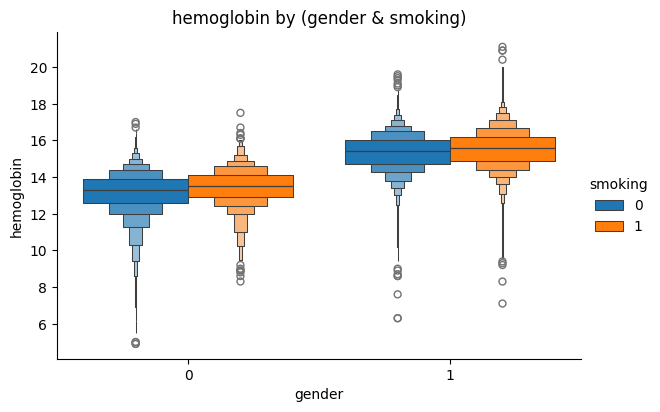

In [75]:
sns.catplot(data=df, x='gender', y='hemoglobin', hue='smoking',
            kind='boxen', saturation=1, height=4, aspect=1.5 
            ).set(title='hemoglobin by (gender & smoking)')

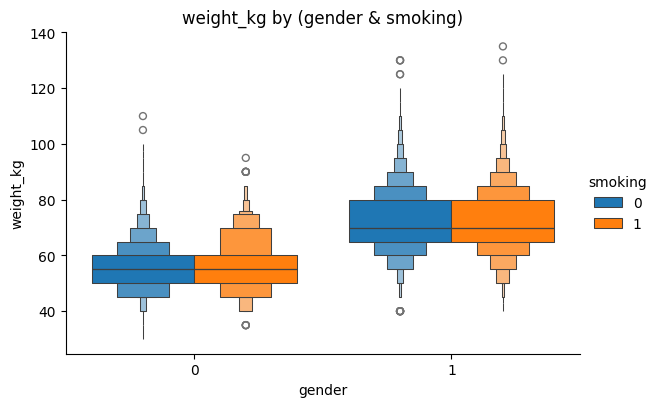

In [76]:
sns.catplot(data=df, x='gender', y='weight_kg', hue='smoking',
            kind='boxen', saturation=1, height=4, aspect=1.5 
            ).set(title='weight_kg by (gender & smoking)')